## Setup

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras

2022-10-07 12:47:20.139225: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-07 12:47:20.255173: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-10-07 12:47:20.258146: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-07 12:47:20.258155: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not ha

In [4]:
def B_vs_V(x:np.array, y1:np.array, y2:np.array, y3:np.array):
    """plots y1, y2, and y3 vs x and returns the corresponding slopes"""
    index = x != 0 # Indexes for which v is non-zero
    x, y1, y2, y3 = x[index], y1[index], y2[index], y3[index] # Values for which v is non-zero

    # Plot
    fig, ax = plt.subplots()
    ax.plot(x, y1, label=r'$B_x$', linewidth=4.0)
    ax.plot(x, y2, label=r'$B_y$', linewidth=4.0)
    ax.plot(x, y3, label=r'$B_z$', linewidth=4.0)
    ax.set_xlabel(r'$V_1$ (arb. u.)')
    ax.set_ylabel('Field (arb. u.)' )
    #ax.set_xlim(0,1)
    ax.legend(loc=0)
    ax.grid()
    return ax

## Generate non-linearity

Our electromagnet model provides linear relationship between the voltage and field. In order to explore non-linear relationship, we need to introduce non-linearity by hand.
We will do it  by applying tanh element-wise to the field values.

In [5]:
#Training data
df = pd.read_csv('data/individual_calibration_set.csv')

Bx, By, Bz = df['B_x'].to_numpy(), df['B_y'].to_numpy(), df['B_z'].to_numpy() # Extract fields
V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

V_train = np.stack((V1, V2, V3), axis=1)
nf = 15 # Non-linearity factor

V_train = np.tanh(V_train/nf)*10

M_ = np.loadtxt('data/lin_cal_mat.csv')
M = np.linalg.inv(M_)
# Introduce non-linearity
Bx, By, Bz = np.tanh(Bx/nf)*np.max(Bx), np.tanh(By/nf)*np.max(By), np.tanh(Bz/nf)*np.max(Bz)

B_train = []

for V in V_train:
    B_train.append(np.dot(M, V))

B_train = np.array(B_train)

In [6]:
B_train

array([[-3.09067329e+01,  1.19757275e-15, -1.03022443e+01],
       [-3.08131982e+01,  1.19394847e-15, -1.02710661e+01],
       [-3.07193732e+01,  1.19031294e-15, -1.02397911e+01],
       ...,
       [-1.53596866e+01, -2.66037576e+01,  1.02397911e+01],
       [-1.54065991e+01, -2.66850124e+01,  1.02710661e+01],
       [-1.54533665e+01, -2.67660159e+01,  1.03022443e+01]])

## Plot non-linear data

<AxesSubplot: xlabel='$V_1$ (arb. u.)', ylabel='Field (arb. u.)'>

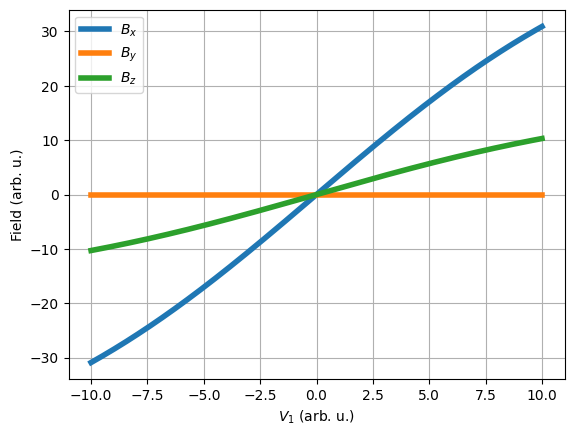

In [8]:
B_vs_V(V1, B_train[:,0], B_train[:,1], B_train[:,2])

Text(0.5, 0, '$V_2$ (arb. u.)')

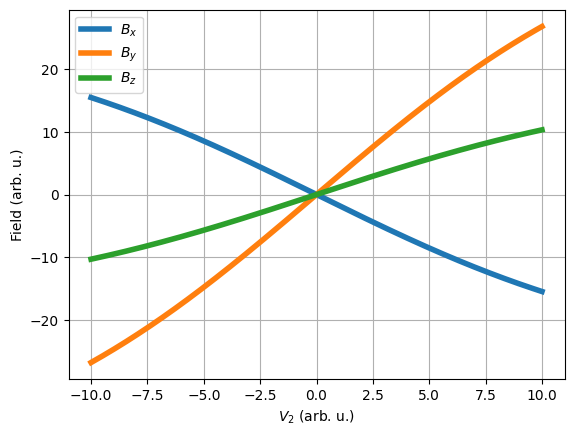

In [9]:
ax2 = B_vs_V(V2, B_train[:,0], B_train[:,1], B_train[:,2])
ax2.set_xlabel(r'$V_2$ (arb. u.)')

Text(0.5, 0, '$V_3$ (arb. u.)')

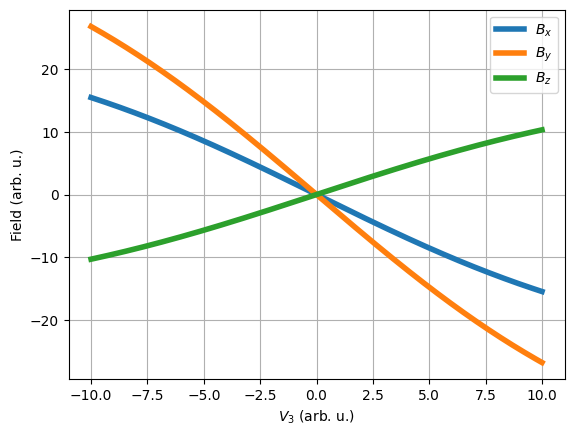

In [10]:
ax3 = B_vs_V(V3, B_train[:,0], B_train[:,1], B_train[:,2])
ax3.set_xlabel(r'$V_3$ (arb. u.)')

## 'Deep' learning

### Load and prepare data

In [8]:
# Full calibration data
df = pd.read_csv('data/full_calibration_set.csv')

Bx, By, Bz = df['B_x'].to_numpy(), df['B_y'].to_numpy(), df['B_z'].to_numpy() # Extract fields
V1, V2, V3 = df['V_1'].to_numpy(), df['V_2'].to_numpy(), df['V_3'].to_numpy()  # Extract voltages

# Introduce non-linearity
nf = 15 # Non-linearity factor
Bx, By, Bz = np.tanh(Bx/nf)*np.max(Bx), np.tanh(By/nf)*np.max(By), np.tanh(Bz/nf)*np.max(Bz)

# Stack data for the network
B_train = np.stack((Bx, By, Bz), axis=1)
V_train = np.stack((V1, V2, V3), axis=1)

In [3]:
# Validation data
df_val = pd.read_csv('data/validation_set.csv')

Bx_val, By_val, Bz_val = df_val['B_x'].to_numpy(), df_val['B_y'].to_numpy(), df_val['B_z'].to_numpy() # Extract fields
V1_val, V2_val, V3_val = df_val['V_1'].to_numpy(), df_val['V_2'].to_numpy(), df_val['V_3'].to_numpy()  # Extract voltages

# Introduce non-linearity
nf = 15 # Non-linearity factor
Bx_val, By_val, Bz_val = np.tanh(Bx_val/nf)*np.max(Bx_val), np.tanh(By_val/nf)*np.max(By_val), np.tanh(Bz_val/nf)*np.max(Bz_val)

# Stack data for the network
B_val = np.stack((Bx_val, By_val, Bz_val), axis=1)
V_val = np.stack((V1_val, V2_val, V3_val), axis=1)

### Create and train neural network

In [30]:
# Initialize model
model = keras.models.Sequential([
    keras.layers.Dense(3),
    keras.layers.Dense(8,activation='relu'),
    keras.layers.Dense(3)
])

In [31]:
# Compile model
model.compile(loss="mse", optimizer = keras.optimizers.Adam(), metrics=["mae"])

In [32]:
# Add callbacks

# Stops training if the mean absolute error does not improve for 300 epochs
early_stopping_cb = keras.callbacks.EarlyStopping(patience=500, monitor='val_mae',restore_best_weights=True)
# Saves the best model
checkpoint_cb = keras.callbacks.ModelCheckpoint(filepath="models.hdf5",save_best_only=True, monitor='val_mae')

In [33]:
# Train model
history = model.fit(B_train, V_train, epochs=1000, validation_data=(B_val, V_val),batch_size=8,callbacks=[checkpoint_cb, early_stopping_cb]);

Epoch 1/1000
313/313 [==============================] - 0s 1ms/step - loss: 735.4993 - mae: 17.2270 - val_loss: 191.0057 - val_mae: 10.0669
Epoch 2/1000
313/313 [==============================] - 0s 648us/step - loss: 136.0959 - mae: 7.6766 - val_loss: 76.4276 - val_mae: 6.5619
Epoch 3/1000
313/313 [==============================] - 0s 631us/step - loss: 50.5686 - mae: 4.7659 - val_loss: 38.6124 - val_mae: 5.1852
Epoch 4/1000
313/313 [==============================] - 0s 622us/step - loss: 20.3996 - mae: 3.3086 - val_loss: 26.9363 - val_mae: 4.3585
Epoch 5/1000
313/313 [==============================] - 0s 618us/step - loss: 14.7002 - mae: 2.7712 - val_loss: 23.0683 - val_mae: 4.0276
Epoch 6/1000
313/313 [==============================] - 0s 617us/step - loss: 12.4578 - mae: 2.5158 - val_loss: 21.0399 - val_mae: 3.8137
Epoch 7/1000
313/313 [==============================] - 0s 615us/step - loss: 11.1296 - mae: 2.3694 - val_loss: 19.7511 - val_mae: 3.6738
Epoch 8/1000
313/313 [=========

(0.0, 5.0)

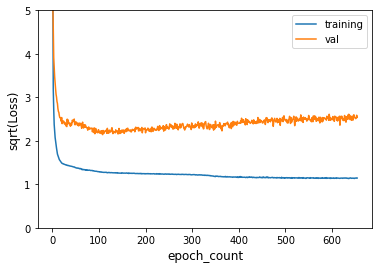

In [29]:
# Plot training process

h = history.history

training_loss = np.array(h["loss"])
test_loss = np.array(h["val_loss"])
epoch_count = np.arange(len(training_loss)) + 1

fig, ax = plt.subplots()
ax.plot(epoch_count, np.sqrt(training_loss), label='training')
ax.plot(epoch_count, np.sqrt(test_loss), label='val')
ax.set_xlabel(r'epoch_count', fontsize=12)
ax.set_ylabel(r'sqrt(Loss)', fontsize=12)
ax.legend(loc=0)
ax.set_ylim(0, 5)

## Analysis

As we can see above, the network does not perform too well. Let's taka a closer look at the calibration and validation data

Text(0.5, 0, '$V_{1}$')

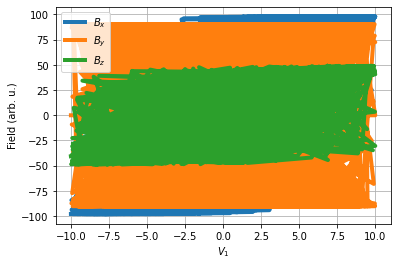

In [36]:
# Take a look at the calibration data
ax = B_vs_V(V1, Bx, By, Bz)
ax.set_xlabel(r'$V_{1}$')

Text(0.5, 0, '$V_{1, val}$')

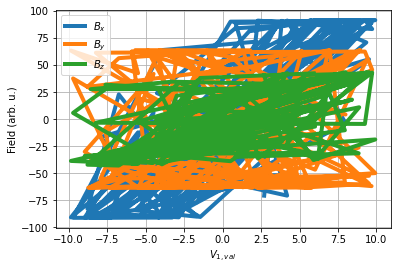

In [35]:
# Take a look at the validation data
ax = B_vs_V(V1_val, Bx_val, By_val, Bz_val)
ax.set_xlabel(r'$V_{1, val}$')